In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from utils import *
import os

In [31]:
def get_intervals(predictions):
    intervals = []
    start = None
    for i, label in enumerate(predictions):
        if label == 1 and start is None:
            start = i
        elif label == 0 and start is not None:
            end = i - 1
            intervals.append((start, end))
            start = None
    if start is not None:
        intervals.append((start, len(predictions) - 1))
    return intervals




In [ ]:
# File loading 

files_directory = "spot-the-trend-test-data/"


In [26]:
import os

# load files 

#train_dir = os.listdir("data/train/")
#train_files = [file for file in train_dir if "intervals" not in file and "example" in file]
#train_intervals = [file for file in train_dir if "intervals" in file and "example" in file]

train_dir = os.listdir(files_directory)

train_files = [file for file in train_dir if "intervals" not in file]



In [72]:
# Dataset generation 

def load_data(files_directory, train = True):

    file_list = os.listdir(files_directory)
    

    if train:
        file_list = [file for file in file_list if "intervals" not in file and "example" in file]
        lables_list = [file for file in file_list if "intervals" in file and "example" in file]

    
         
    df = pd.DataFrame()

    for i, filename in enumerate(file_list):

        data = pd.read_csv(files_directory + filename,sep="\t", index_col=0)

        

        # Add machine number
        data["machine"] = i + 1

        # Check for nan values and fill with interpolation and backfill
        data["y"] = data["y"].interpolate(method="linear").bfill()


        df = pd.concat([df, data])

    return df


In [73]:
# Load Files 

df = load_data("data/train/")

In [27]:
# Load series in dataframe

df = pd.DataFrame()

for i, filename in enumerate(train_files):

    data = pd.read_csv(files_directory + filename,sep="\t", index_col=0)

    # Add machine number
    data["machine"] = i + 1

    # Check for nan values
    data["y"] = data["y"].interpolate(method="linear").bfill()


    df = pd.concat([df, data])

In [20]:
# Load series in dataframe

df = pd.DataFrame()

for i, filename in enumerate(train_files):

    data = pd.read_csv("data/train/" + filename,sep="\t", index_col=0)

    # Add machine number
    data["machine"] = i + 1

    # Check for nan values
    data["y"] = data["y"].interpolate(method="linear").bfill()


    df = pd.concat([df, data])

FileNotFoundError: [Errno 2] No such file or directory: 'data/train/apgjp.csv'

In [ ]:
for machine_id,data in df.groupby("machine"):

    ground_truth_label = pd.read_csv("data/train/" + train_files[machine_id-1][:-4]  + "_intervals.csv")

    # Add labels
    on_intervals = list(zip(ground_truth_label.start, ground_truth_label.stop))
    
    data["label"] = 0 
    for start, end in on_intervals:
        data.loc[start:end, 'label'] = 1

In [40]:
def initial_model(df):

    for machine_id,data in df.groupby("machine"):
        print(f"Machine: {machine_id}")
        data = data.copy()

        data["y_500_avg"] = data["y"].copy()
        data["y_500_avg"] = data["y_500_avg"].rolling(window=500, min_periods=1).mean()

        data['difference'] = data["y_500_avg"].diff(periods = 1000)

        data['difference'] = data["difference"].fillna(0)

        # Define a threshold for significant changes
        threshold = 125 # Adjust based on your data characteristics

        # Identify points with significant changes
        data['significant_change'] = np.abs(data['difference']) > threshold
        
        
        change = [value for value in data.index[data['significant_change']] if value-1 not in data.index[data['significant_change']] ]
        starts = change[::2]
        ends = change[1::2]

        intervals = [(starts[i], ends[i]) for i in range(len(ends))]


        data['first_guess'] = 0 
        for start, end in intervals:
            data.loc[start:end, 'first_guess'] = 1

        

        data["first_guess_10"] = data["first_guess"].shift(-10)

        data["first_guess_10"] = data["first_guess_10"].fillna(0)


        data["first_guess_100"] = data["first_guess"].shift(-100)

        data["first_guess_100"] = data["first_guess_100"].fillna(0)


        data["first_guess_1000"] = data["first_guess"].shift(-1000)

        data["first_guess_1000"] = data["first_guess_1000"].fillna(0)




        # Save in original dataset

        df.loc[data.index, 'y_500_avg'] = data['y_500_avg']
        df.loc[data.index, 'difference'] = data['difference']
        df.loc[data.index, 'significant_change'] = data['significant_change']

        df.loc[data.index, 'first_guess'] = data['first_guess']
        df.loc[data.index, 'first_guess_10'] = data['first_guess_10']
        df.loc[data.index, 'first_guess_100'] = data['first_guess_100']
        df.loc[data.index, 'first_guess_1000'] = data['first_guess_1000']


In [75]:
direct = "data/train/"

df =  load_data(direct)



initial_model(df)

Machine: 1
Machine: 2


# Test modelo dado 


In [4]:
file_directory = "spot-the-trend-train-data/"

# and "example" in file
train_dir = os.listdir(file_directory)

## OJO A CARGAR FICHEROS SI HAY OTRAS CARPETAS DENTRO DEL DIRECTORIO 
train_files = [file_directory + file for file in train_dir if "intervals" not in file ]
train_intervals = [file_directory + file for file in train_dir if "intervals" in file ]

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'spot-the-trend-train-data/'

In [110]:


#train_intervals = [interval for interval in train_intervals]
true_intervals = [list(zip(pd.read_csv(interval_file).start, pd.read_csv(interval_file).stop)) for interval_file in train_intervals]

In [113]:
only_train=add_intervals(train_files,true_intervals,is_actual=True)

In [98]:
model=SimpleModel(0,0)

In [99]:
model.fit(only_train)

Machine n: 1


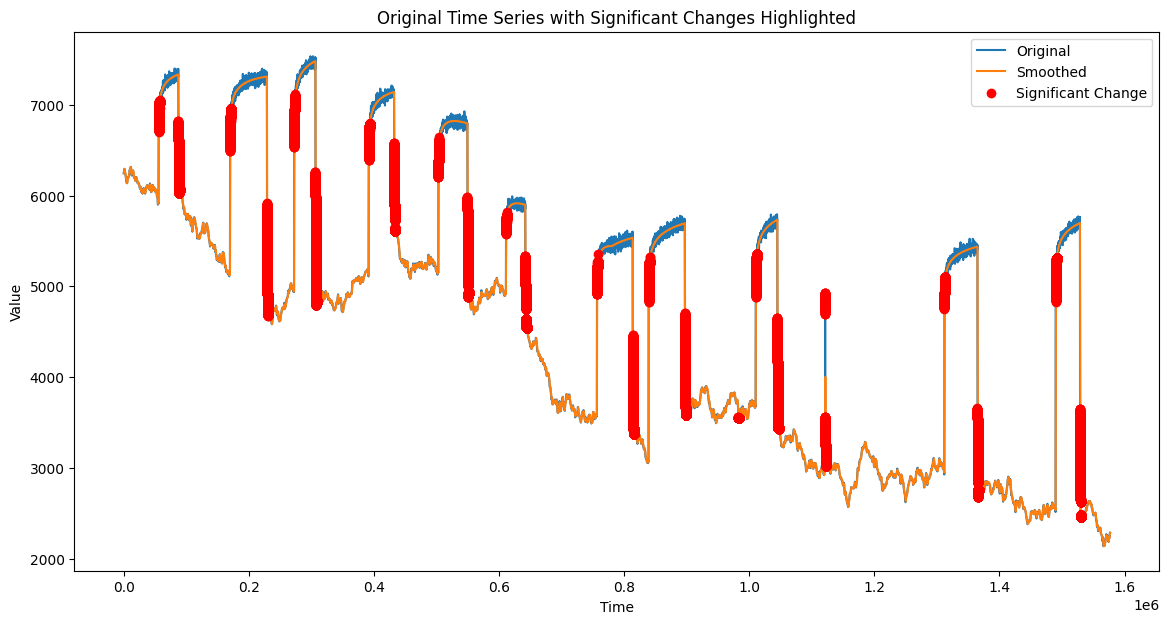

Machine n: 2


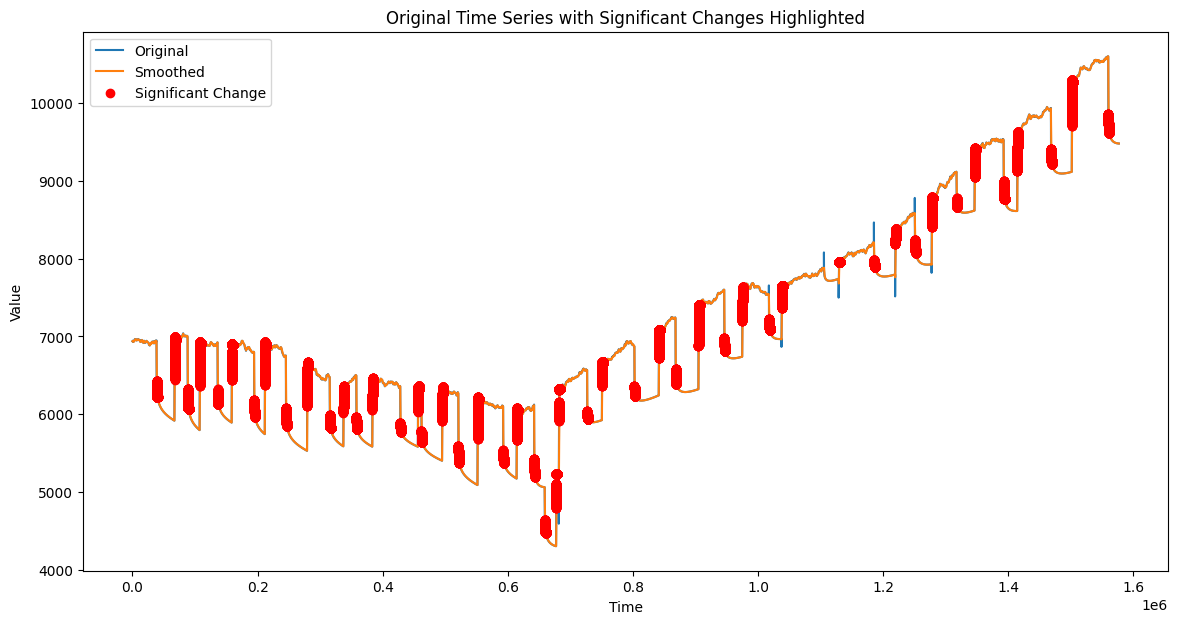

Machine n: 3


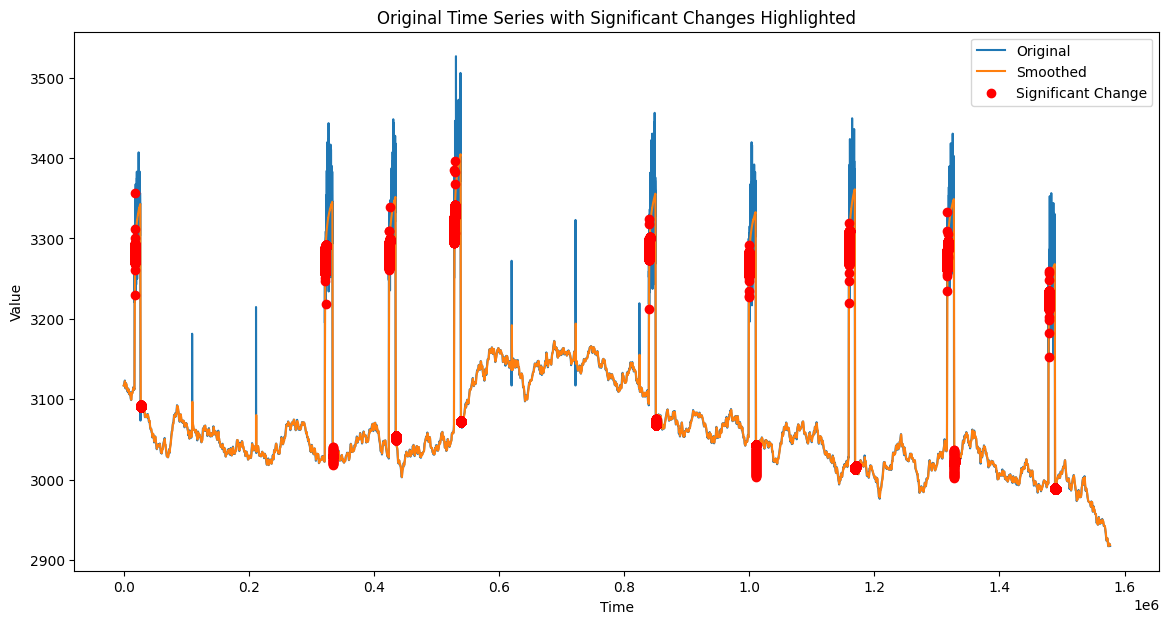

Machine n: 4


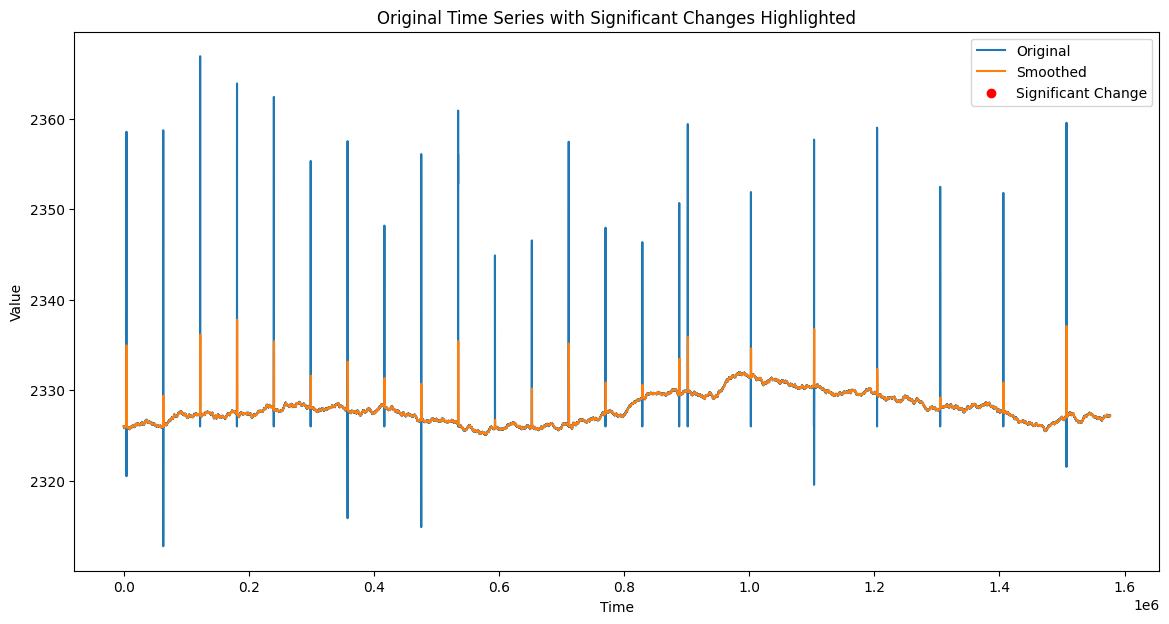

Machine n: 5


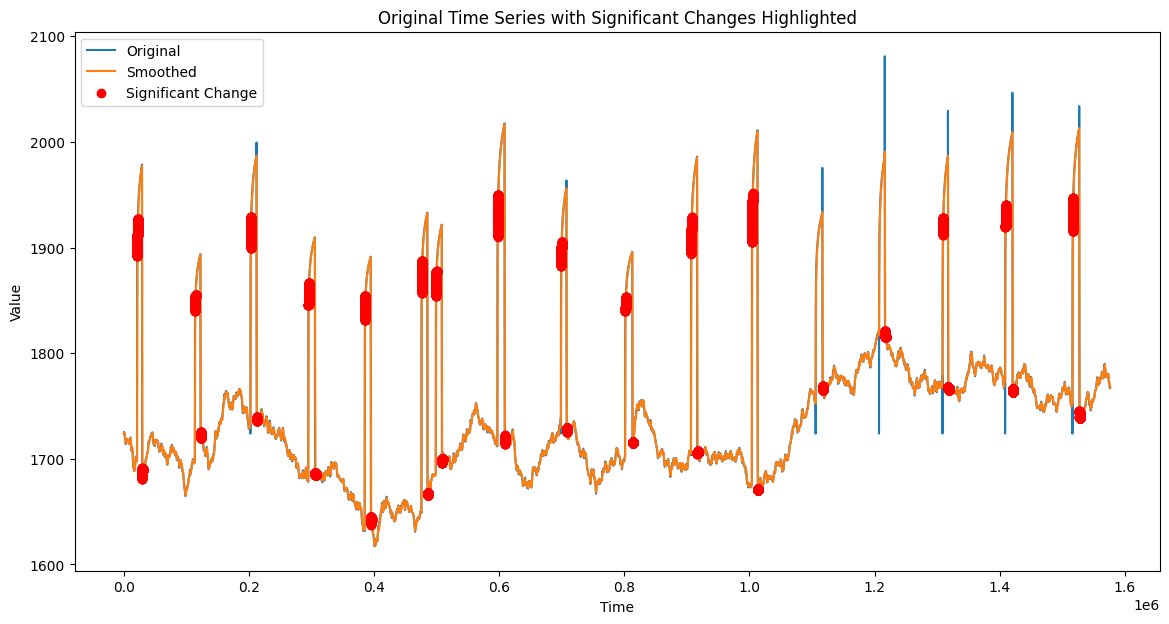

Machine n: 6


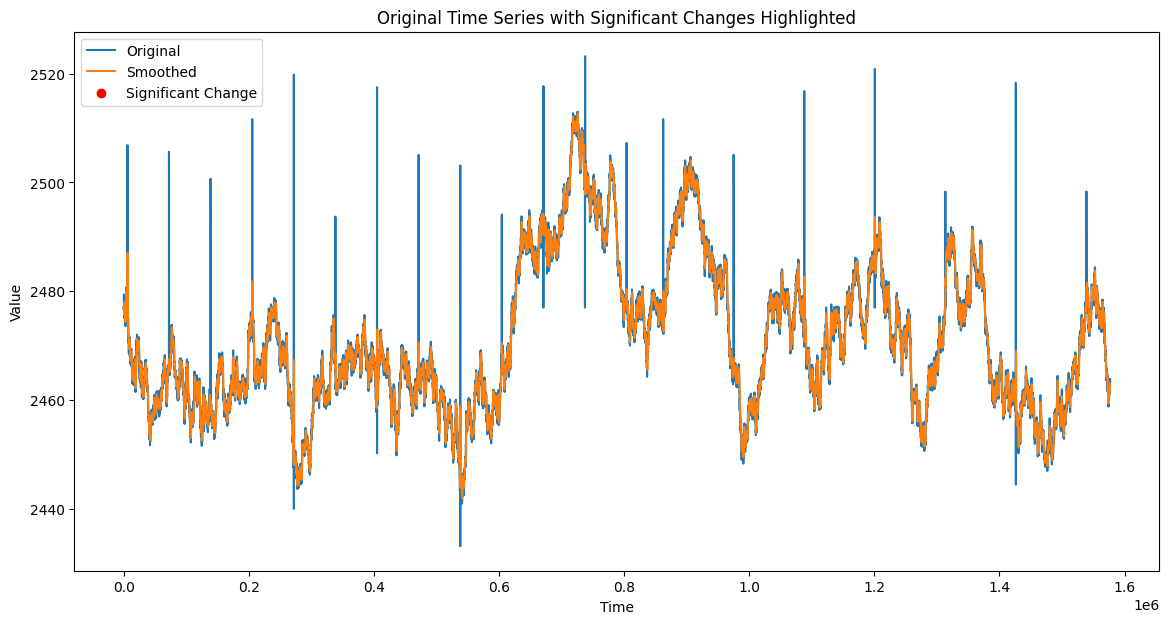

Machine n: 7


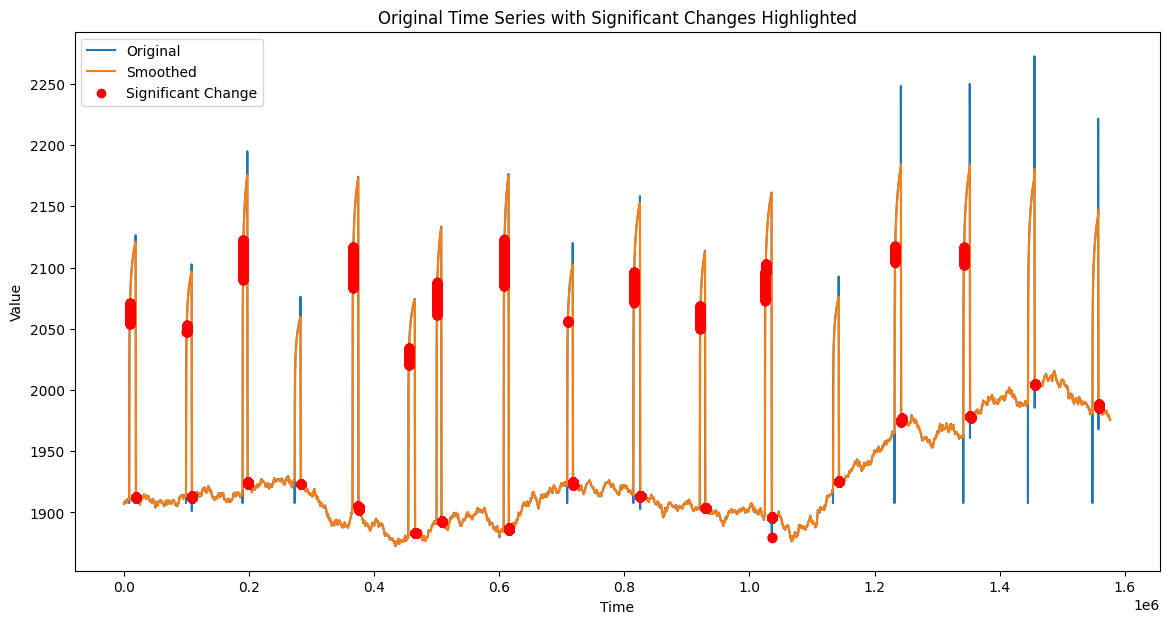

Machine n: 8


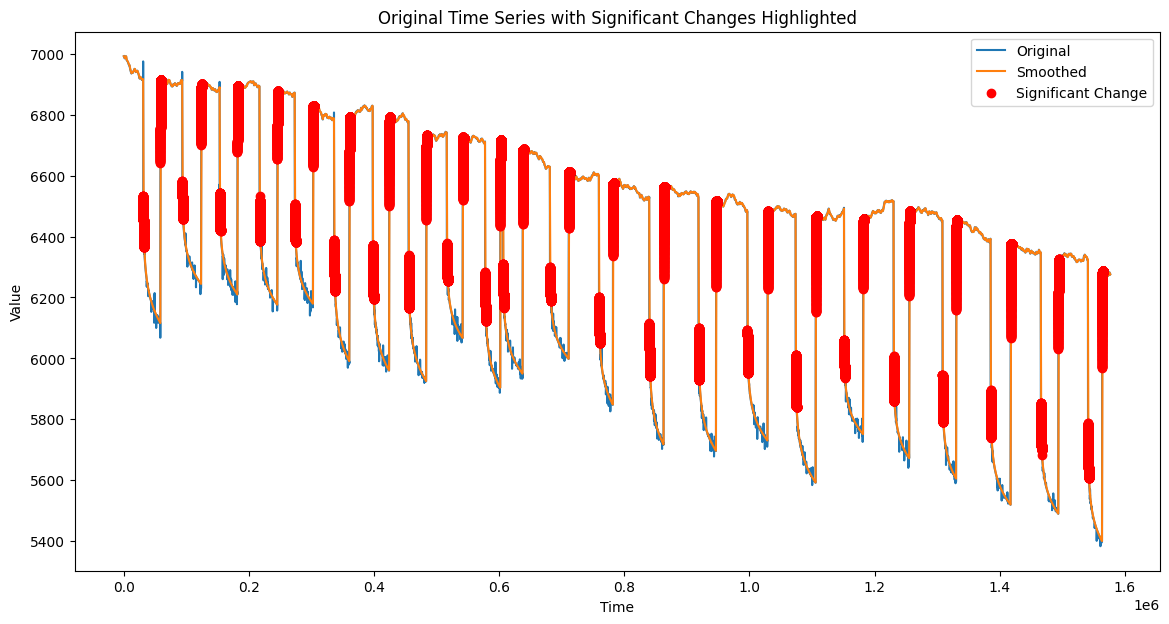

Machine n: 9


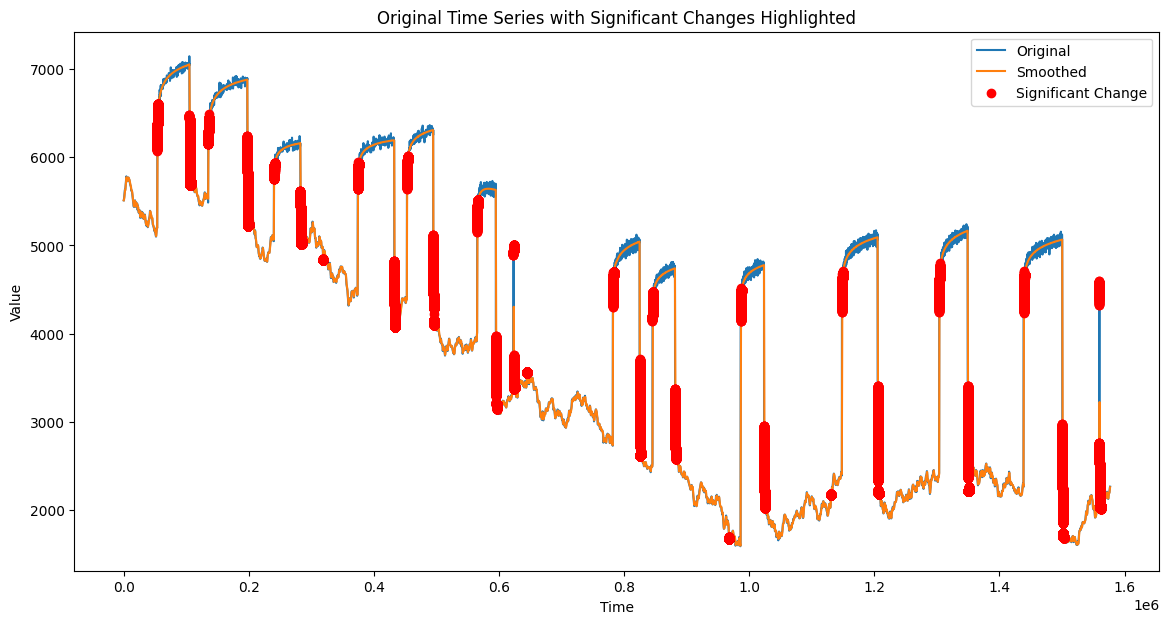

Machine n: 10


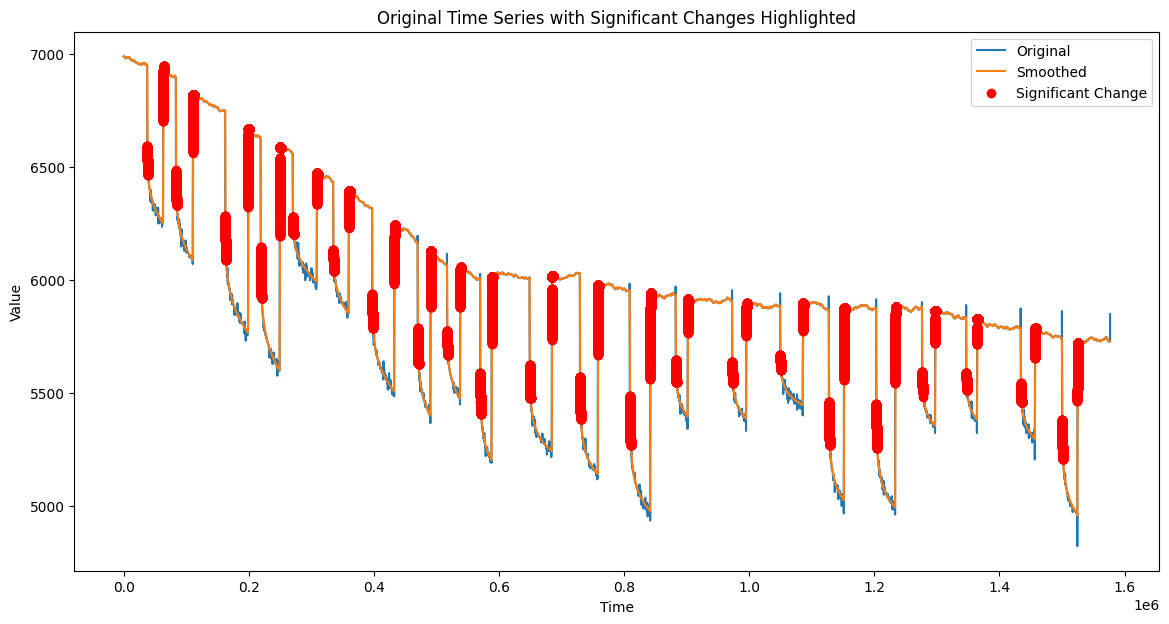

Machine n: 11


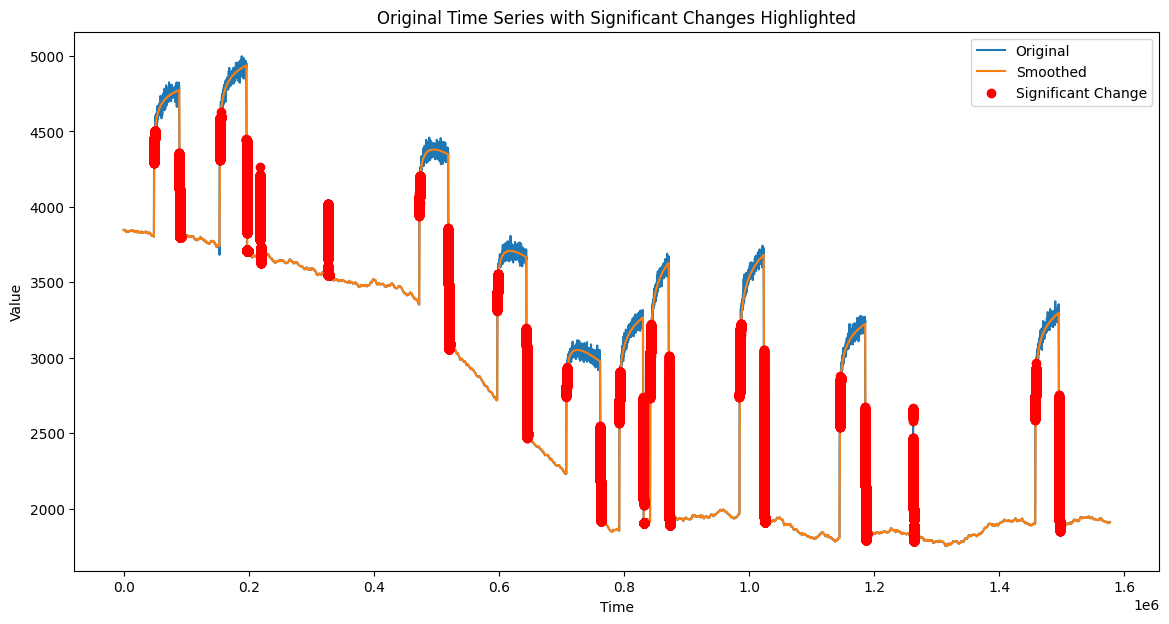

In [29]:
for machine_id,data in df.groupby("machine"):
    print(f"Machine n: {machine_id}")
    data = data.copy()

    data["y_500_avg"] = data["y"].copy()
    data["y_500_avg"] = data["y_500_avg"].rolling(window=500, min_periods=1).mean()

    data['difference'] = data["y_500_avg"].diff(periods = 1000)

    data['difference'] = data["difference"].fillna(0)

    # Define a threshold for significant changes
    threshold = 125 # Adjust based on your data characteristics

    # Identify points with significant changes
    data['significant_change'] = np.abs(data['difference']) > threshold
    
    
    change = [value for value in data.index[data['significant_change']] if value-1 not in data.index[data['significant_change']] ]
    starts = change[::2]
    ends = change[1::2]

    intervals = [(starts[i], ends[i]) for i in range(len(ends))]


    data['first_guess'] = 0 
    for start, end in intervals:
        data.loc[start:end, 'first_guess'] = 1

    

    data["first_guess_10"] = data["first_guess"].shift(-10)

    data["first_guess_10"] = data["first_guess_10"].fillna(0)


    data["first_guess_100"] = data["first_guess"].shift(-100)

    data["first_guess_100"] = data["first_guess_100"].fillna(0)


    data["first_guess_1000"] = data["first_guess"].shift(-1000)

    data["first_guess_1000"] = data["first_guess_1000"].fillna(0)




    # Save in original dataset

    df.loc[data.index, 'y_500_avg'] = data['y_500_avg']
    df.loc[data.index, 'difference'] = data['difference']
    df.loc[data.index, 'significant_change'] = data['significant_change']

    df.loc[data.index, 'first_guess'] = data['first_guess']
    df.loc[data.index, 'first_guess_10'] = data['first_guess_10']
    df.loc[data.index, 'first_guess_100'] = data['first_guess_100']
    df.loc[data.index, 'first_guess_1000'] = data['first_guess_1000']

    # # Plot the original time series and highlight points with significant changes
    # plt.figure(figsize=(14, 7))
    # plt.plot(data['y'], label='Original')
    # plt.plot(data['y_500_avg'], label='Smoothed')
    # plt.scatter(data.index[data['significant_change']], data['y'][data['significant_change']], color='red', label='Significant Change', zorder=5)
    # plt.xlabel('Time')
    # plt.ylabel('Value')
    # plt.title('Original Time Series with Significant Changes Highlighted')
    # plt.legend()
    # plt.show()

In [ ]:
df = df.replace({True: 1, False: 0})

df["grad"] = np.gradient(df["y"].values)

C:\Users\DPonsoda\AppData\Local\Temp\ipykernel_11932\585036720.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


In [30]:
df.shape

(17344802, 10)

In [32]:
intervals = []

for machine_id,data in df.groupby("machine"):

    interval_machine = get_intervals(data['first_guess'])
    intervals.append(interval_machine)

In [33]:
sam_sub = {("test_lables/" +train_files[i]):intervals[i] for i in range(len(train_files))}

In [34]:
sam_sub

{'test_lables/apgjp.csv': [(48586, 89101),
  (153434, 196470),
  (217816, 218953),
  (326195, 327322),
  (472723, 519078),
  (597380, 643994),
  (707830, 761922),
  (792472, 830424),
  (841714, 871388),
  (984564, 1023379),
  (1144566, 1185571),
  (1261996, 1263097),
  (1457462, 1495024)],
 'test_lables/bafgr.csv': [(48586, 89101),
  (153434, 196470),
  (217816, 218953),
  (326195, 327322),
  (472723, 519078),
  (597380, 643994),
  (707830, 761922),
  (792472, 830424),
  (841714, 871388),
  (984564, 1023379),
  (1144566, 1185571),
  (1261996, 1263097),
  (1457462, 1495024)],
 'test_lables/bzjeg.csv': [(48586, 89101),
  (153434, 196470),
  (217816, 218953),
  (326195, 327322),
  (472723, 519078),
  (597380, 643994),
  (707830, 761922),
  (792472, 830424),
  (841714, 871388),
  (984564, 1023379),
  (1144566, 1185571),
  (1261996, 1263097),
  (1457462, 1495024)],
 'test_lables/ceeng.csv': [(48586, 89101),
  (153434, 196470),
  (217816, 218953),
  (326195, 327322),
  (472723, 519078),
  (5

In [38]:
save_submission_to_json(sam_sub, "submissions\sub1.json")